# Numerai

In [3]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest v4.1 dataset
[f for f in napi.list_datasets() if f.startswith("v4.2")]

['v4.2/features.json',
 'v4.2/live_example_preds.csv',
 'v4.2/live_example_preds.parquet',
 'v4.2/live_int8.parquet',
 'v4.2/meta_model.parquet',
 'v4.2/train_int8.parquet',
 'v4.2/validation_example_preds.csv',
 'v4.2/validation_example_preds.parquet',
 'v4.2/validation_int8.parquet']

In [4]:
import pandas as pd
import json

# Download the training data and feature metadata
# This may take a few minutes

train = "v4.2/train_int8.parquet"
features = "v4.2/features.json"


napi.download_dataset(train);
napi.download_dataset(features);

# Load the training data but only the "small" subset of features to save time and memory
# In practice you will want to use all the features to maximize your model's performance
feature_metadata = json.load(open(features)) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet(train, columns= ["era"] + feature_cols + ["target"]) 

real_submition = True
if real_submition:
# For better models, join train and validation data and train on all of it
    napi.download_dataset("v4.2/validation_int8.parquet");
    validation = pd.read_parquet("v4.2/validation_int8.parquet", columns=["era", "data_type"]+feature_cols+["target"])
    validation = validation[validation["data_type"] == "validation"] # drop rows which don't have targets yet
    training_data = pd.concat([training_data, validation])



# downsample para cada 4rt era , assim nao trein
training_data = training_data[training_data["era"].isin(training_data["era"].unique()[::4])]

training_data

2023-09-09 04:28:46,395 INFO numerapi.utils: target file already exists
2023-09-09 04:28:46,397 INFO numerapi.utils: download complete
2023-09-09 04:28:47,907 INFO numerapi.utils: target file already exists
2023-09-09 04:28:47,909 INFO numerapi.utils: download complete
2023-09-09 04:28:51,692 INFO numerapi.utils: target file already exists
2023-09-09 04:28:51,694 INFO numerapi.utils: download complete


,era,feature_acclimatisable_unfeigned_maghreb,feature_aged_phylacterical_pusey,feature_asinine_unsatiable_avion,feature_bantam_matterful_hut,feature_community_premandibular_fervor,feature_confabulatory_malarian_phenotype,feature_correspondent_orderly_personalisation,feature_deliquescent_pelvic_functionary,feature_detectable_fogbound_dicastery,...,feature_unhorsed_morphogenetic_affusion,feature_unprotested_euphoric_engram,feature_unreproving_capsian_decolourization,feature_unscriptural_coconut_trisulphide,feature_unsuiting_enuretic_milometer,feature_unventilated_sollar_bason,feature_ventriloquistic_relegable_optometer,feature_wistful_tussive_cycloserine,target,data_type
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,4,0.25,NaN
n003bee128c2fcfc,0001,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,3,0.75,NaN
n0048ac83aff7194,0001,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,4,2,0,0.25,NaN
n00691bec80d3e02,0001,1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,3,2,0,0.75,NaN
n00b8720a2fdc4f2,0001,0,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,3,0.50,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nff9694d7c110513,1073,2,4,4,2,4,3,4,3,1,...,3,2,4,4,4,3,0,2,0.50,validation
nffa11825d8ce071,1073,1,3,3,0,3,4,2,4,1,...,4,3,4,0,0,0,3,2,0.50,validation
nffa4d6e827c1ebb,1073,4,1,3,1,3,3,4,0,1,...,0,4,4,0,1,4,2,1,0.50,validation


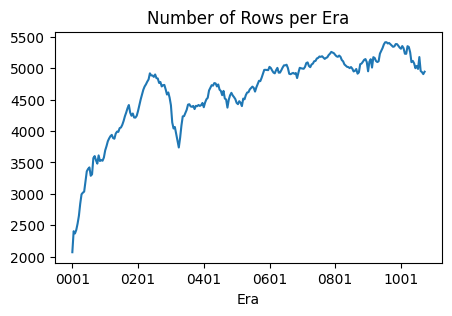

In [6]:
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3), xlabel="Era");

# Modeling
o objetivo aqui é criar um modelo para submeter no numer.ai



## LightGBM
isto faz trees

primeiro vou criar um modelo com as opcoes default dadas pelo numerai para ver como se sai


In [7]:
import lightgbm as lgb

try:
    # load aos modelos de treino se ja existir
    model = lgb.Booster(model_file='small_lgbm_tree.model');
except lgb.basic.LightGBMError:
    # se naoe xistir criar o modelo e gravar
    model = lgb.LGBMRegressor(
        n_estimators = 2000,
        learning_rate = 0.01,
        max_depth = 5,
        num_leaves = 2**5-1,
        colsample_bytree = 0.1
    )

    #treinar o modelo
    model.fit(
        training_data[feature_cols],
        training_data["target"]
    )

    # gravar o modelo
    model.booster_.save_model("small_lgbm_tree.model")

[LightGBM] [Fatal] Could not open small_lgbm_tree.model


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1243946, number of used features: 42
[LightGBM] [Info] Start training from score 0.499995


testar o modelo agora



Definir a funcao de scoring para corr
esta é a maneira principal de scoring do numerai

In [8]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standardize prediction distributions
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0
    centered_target = target - target.mean()
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [10]:
# Download validation data 
# This will take a few minutes 🍵
napi.download_dataset("v4.2/validation_int8.parquet");

# Load the validation data, filtering for data_type == "validation"
validation_data = pd.read_parquet("v4.2/validation_int8.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (higher memory usage, slower inference, more accurate evaluation)
validation_data = validation_data[validation_data["era"].isin(validation_data["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 4 weeks into the future, so we need to "embargo" the 4 eras following our last train era to avoid data leakage. 
last_train_era = int(training_data["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation_data = validation_data[~validation_data["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]

2023-09-09 04:43:39,342 INFO numerapi.utils: target file already exists
2023-09-09 04:43:39,344 INFO numerapi.utils: download complete


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,era,prediction,target
id,,,
n000101811a8a843,0575,0.498171,0.75
n001e1318d5072ac,0575,0.503785,0.00
n002a9c5ab785cbb,0575,0.497314,0.50
n002ccf6d0e8c5ad,0575,0.511184,0.00
n0051ab821295c29,0575,0.491287,0.50
...,...,...,...
nffd5af15959f152,1071,0.495073,0.50
nffd9899640fa670,1071,0.508153,0.25
nffdc9ed5105d9c3,1071,0.501140,0.50


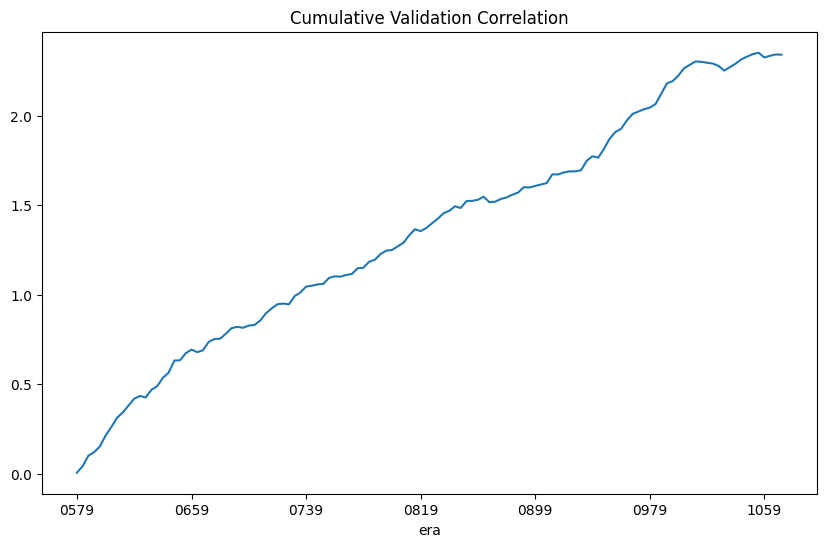

In [10]:
# Plot da corr/cummulatia / era, mais util porque permite ter nocao de "quanto ganha"__qualname__ 
per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));


In [11]:
# scoring data function
def scoring_data(model, validation_data, feature_cols):
    # Generate predictions against the out-of-sample validation features
    # This will take a few minutes 🍵
    validation_data["prediction"] = model.predict(validation_data[feature_cols])
    validation_data[["era", "prediction", "target"]]
    per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

    # Compute performance metrics
    corr_mean = per_era_corr.mean()
    corr_std = per_era_corr.std(ddof=0)
    corr_sharpe = corr_mean / corr_std
    max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

    return pd.DataFrame({
        "mean": corr_mean,
        "std": corr_std,
        "sharpe": corr_sharpe,
        "max_drawdown": max_drawdown
    }, index=["Value"]).T


scoring_data(model, validation_data, feature_cols)

    

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Value
mean,0.039221
std,0.019206
sharpe,2.042119
max_drawdown,0.012442


In [12]:
# Define predict function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")


In [14]:
# picklar a funcao
import cloudpickle

p = cloudpickle.dumps(predict)
with open("small_lgbm_tree.pkl", "wb") as f:
    f.write(p)

## XGBoost
mesma coisa mas com xgboost


In [ ]:
import numpy as np
import xgboost as xgb


# Initialize the XGBoost regression model tree
model = xgb.XGBRegressor(
    n_estimators = 2000,
    learning_rate = 0.01,
    max_depth = 5,
    num_leaves = 2**5,
    colsample_bytree = 0.1,
    #tree_method='gpu_hist',
    #gpu_id= 0,
    random_state=420
    )

# Train the model on the training data
model.fit(
    training_data[feature_cols],
    training_data["target"]
    )

# dl do dataset de validation
napi.download_dataset("v4.1/validation.parquet")
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# load do dataset de treino
validation_data = validation_data[validation_data["data_type"] == "validation" ]
del validation_data["data_type"]

# gerar as previsoes
validation_data["prediction"] = model.predict(validation_data[feature_cols])
validation_data[["era", "prediction", "target"]]
 

: 

In [ ]:
# gravar o modelo
model.booster_.save_model("small_xgb_tree.model")


In [ ]:

# correlacao /era das previsoes com o metamodelo + um plot

per_era_corr = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))
per_era_corr.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

In [ ]:
# Plot da corr/cummulatia / era, mais util porque permite ter nocao de "quanto ganha"__qualname__ 
per_era_corr.cumsum().plot(kind="line", title="Cumulative Validation Correlation", figsize=(10, 6));